# Unit05_K_Means | K-平均分群演算法

本 Notebook 使用模擬的化工反應器操作數據建立 K-Means 分群模型來識別不同的操作模式。

## 目標
- 理解 K-Means 演算法的核心原理與實作流程
- 學習使用手肘法與輪廓分析選擇最佳 K 值
- 掌握特徵標準化在分群中的重要性
- 應用 K-Means 於化工反應器操作模式識別
- 視覺化與解釋分群結果

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit05_K_Means'
SOURCE_DATA_DIR = 'reactor_simulation'

try:
    from google.colab import drive
    IN_COLAB = True
    print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    IN_COLAB = False
    print("✓ 偵測到 Local 環境")

try:
    shortcut_path = '/content/CHE-AI-COURSE'
    os.remove(shortcut_path)
except FileNotFoundError:
    pass

if IN_COLAB:
    source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
    os.symlink(source_path, shortcut_path)
    shortcut_path = Path(shortcut_path)
    if source_path.exists():
        NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit05'
        OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
        DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
        MODEL_DIR = OUTPUT_DIR / 'models'
        FIG_DIR = OUTPUT_DIR / 'figs'
    else:
        print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
    NOTEBOOK_DIR = Path.cwd()
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\data\reactor_simulation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs


In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn 套件
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定 matplotlib 參數
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 1. 生成模擬數據：反應器操作模式

我們將模擬一個化工反應器在不同操作條件下的數據，包含五種明確的操作模式：
- **模式 1 (極高產率模式)**：最高溫度、最大流量、最高產率
- **模式 2 (高產率模式)**：高溫、大流量、高產率
- **模式 3 (中產率模式)**：中溫、中流量、中產率
- **模式 4 (中低產率模式)**：較低溫度、較小流量、中低產率
- **模式 5 (低產率模式)**：低溫、小流量、低產率

**注意**：相鄰模式之間的參數範圍有適度重疊，使分群更具挑戰性。

In [3]:
# 設定隨機種子
np.random.seed(SEED)

# 定義五種操作模式的參數（增加難度，讓相鄰模式有適度重疊）
n_samples_per_mode = 120

# 模式 1: 極高產率模式 (Very High Yield Mode)
mode1 = {
    'Temperature': np.random.normal(375, 6, n_samples_per_mode),      # °C
    'Feed_Flow': np.random.normal(48, 4, n_samples_per_mode),         # m³/h
    'Cooling_Flow': np.random.normal(28, 3, n_samples_per_mode),      # m³/h
    'Stirring_Speed': np.random.normal(390, 20, n_samples_per_mode),  # rpm
    'Product_Conc': np.random.normal(0.84, 0.04, n_samples_per_mode), # mol/L
    'Yield': np.random.normal(86, 3, n_samples_per_mode),             # %
    'Mode': ['Very_High'] * n_samples_per_mode
}

# 模式 2: 高產率模式 (High Yield Mode)
mode2 = {
    'Temperature': np.random.normal(365, 6, n_samples_per_mode),
    'Feed_Flow': np.random.normal(42, 4, n_samples_per_mode),
    'Cooling_Flow': np.random.normal(24, 3, n_samples_per_mode),
    'Stirring_Speed': np.random.normal(350, 20, n_samples_per_mode),
    'Product_Conc': np.random.normal(0.76, 0.04, n_samples_per_mode),
    'Yield': np.random.normal(80, 3, n_samples_per_mode),
    'Mode': ['High'] * n_samples_per_mode
}

# 模式 3: 中產率模式 (Medium Yield Mode)
mode3 = {
    'Temperature': np.random.normal(355, 6, n_samples_per_mode),
    'Feed_Flow': np.random.normal(35, 4, n_samples_per_mode),
    'Cooling_Flow': np.random.normal(20, 3, n_samples_per_mode),
    'Stirring_Speed': np.random.normal(310, 20, n_samples_per_mode),
    'Product_Conc': np.random.normal(0.68, 0.04, n_samples_per_mode),
    'Yield': np.random.normal(72, 3, n_samples_per_mode),
    'Mode': ['Medium'] * n_samples_per_mode
}

# 模式 4: 中低產率模式 (Medium-Low Yield Mode)
mode4 = {
    'Temperature': np.random.normal(340, 6, n_samples_per_mode),
    'Feed_Flow': np.random.normal(28, 4, n_samples_per_mode),
    'Cooling_Flow': np.random.normal(16, 3, n_samples_per_mode),
    'Stirring_Speed': np.random.normal(270, 20, n_samples_per_mode),
    'Product_Conc': np.random.normal(0.58, 0.04, n_samples_per_mode),
    'Yield': np.random.normal(62, 3, n_samples_per_mode),
    'Mode': ['Medium_Low'] * n_samples_per_mode
}

# 模式 5: 低產率模式 (Low Yield Mode)
mode5 = {
    'Temperature': np.random.normal(330, 6, n_samples_per_mode),
    'Feed_Flow': np.random.normal(22, 4, n_samples_per_mode),
    'Cooling_Flow': np.random.normal(12, 3, n_samples_per_mode),
    'Stirring_Speed': np.random.normal(230, 20, n_samples_per_mode),
    'Product_Conc': np.random.normal(0.50, 0.04, n_samples_per_mode),
    'Yield': np.random.normal(54, 3, n_samples_per_mode),
    'Mode': ['Low'] * n_samples_per_mode
}

# 合併五種模式的數據
df_mode1 = pd.DataFrame(mode1)
df_mode2 = pd.DataFrame(mode2)
df_mode3 = pd.DataFrame(mode3)
df_mode4 = pd.DataFrame(mode4)
df_mode5 = pd.DataFrame(mode5)
df = pd.concat([df_mode1, df_mode2, df_mode3, df_mode4, df_mode5], ignore_index=True)

# 隨機打亂數據順序
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"✓ 數據生成完成")
print(f"  總樣本數: {len(df)}")
print(f"  操作模式數: 5")
print(f"  特徵數量: {len(df.columns) - 1}")  # 扣除 Mode 欄位
print(f"\n前5筆數據:")
df.head()

✓ 數據生成完成
  總樣本數: 600
  操作模式數: 5
  特徵數量: 6

前5筆數據:


,Temperature,Feed_Flow,Cooling_Flow,Stirring_Speed,Product_Conc,Yield,Mode
0,363.487373,45.078533,28.932723,384.498966,0.842863,86.633052,Very_High
1,338.517846,25.358715,17.416007,305.172410,0.633157,56.216982,Medium_Low
2,328.446874,23.239996,9.969015,239.503355,0.454360,54.154983,Low
3,373.205956,48.614900,27.069200,362.397971,0.822698,91.256811,Very_High
4,356.987934,40.426645,22.278900,377.514136,0.763040,78.536266,High


---
## 2. 探索性數據分析 (EDA)

In [4]:
# 數據基本資訊
print("=== Dataset Information ===")
print(df.info())
print("\n=== Statistical Summary ===")
df.describe()

=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     600 non-null    float64
 1   Feed_Flow       600 non-null    float64
 2   Cooling_Flow    600 non-null    float64
 3   Stirring_Speed  600 non-null    float64
 4   Product_Conc    600 non-null    float64
 5   Yield           600 non-null    float64
 6   Mode            600 non-null    object 
dtypes: float64(6), object(1)
memory usage: 32.9+ KB
None

=== Statistical Summary ===


,Temperature,Feed_Flow,Cooling_Flow,Stirring_Speed,Product_Conc,Yield
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,353.099360,35.197428,20.067441,311.315101,0.672579,70.772898
std,17.339831,10.430737,6.441002,60.053590,0.126158,12.054452
min,312.053184,10.671378,3.279035,180.243827,0.382822,46.190589
25%,337.621151,26.446688,15.003998,261.831398,0.566432,60.196883
50%,354.907332,35.213782,20.137585,308.509762,0.682990,71.857463
75%,367.389145,43.799879,25.443865,361.106895,0.777318,81.594298
max,389.779453,63.410926,34.399100,451.577616,0.930828,93.720079


=== Mode Distribution (True Labels) ===
Mode
High          120
Low           120
Medium        120
Medium_Low    120
Very_High     120
Name: count, dtype: int64


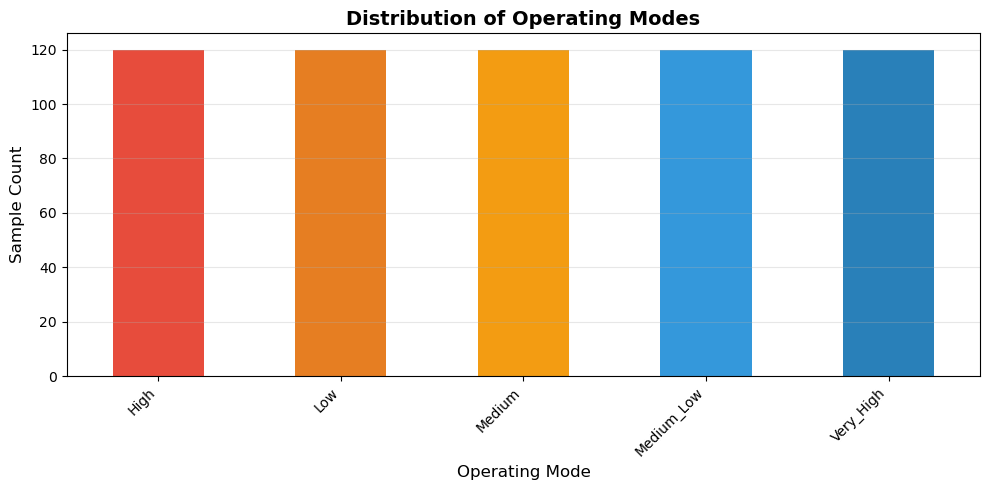


✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\mode_distribution.png


In [5]:
# 檢查每種操作模式的樣本數
print("=== Mode Distribution (True Labels) ===")
print(df['Mode'].value_counts().sort_index())

# 視覺化：各模式的樣本數
fig, ax = plt.subplots(figsize=(10, 5))
mode_counts = df['Mode'].value_counts().sort_index()
colors_palette = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#2980b9']
mode_counts.plot(kind='bar', color=colors_palette, ax=ax)
ax.set_title('Distribution of Operating Modes', fontsize=14, fontweight='bold')
ax.set_xlabel('Operating Mode', fontsize=12)
ax.set_ylabel('Sample Count', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'mode_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖檔已儲存至: {FIG_DIR / 'mode_distribution.png'}")

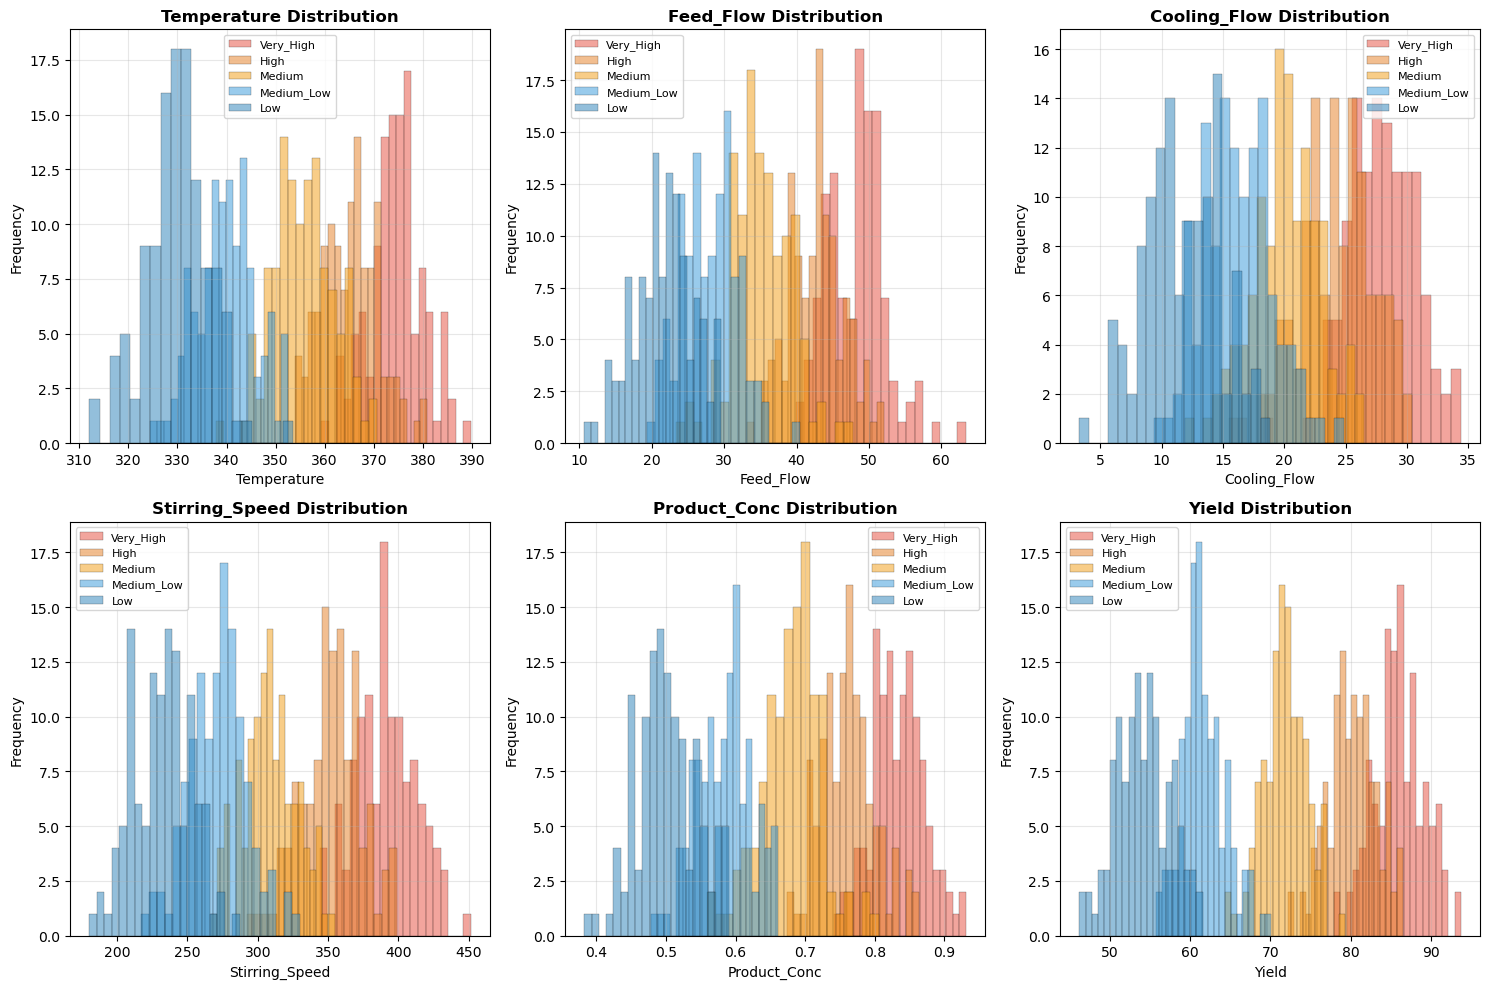

✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\feature_distributions.png

觀察: 相鄰模式之間有明顯的重疊，這將增加分群的挑戰性。


In [6]:
# 視覺化：各特徵的分布（按模式著色）
features = ['Temperature', 'Feed_Flow', 'Cooling_Flow', 'Stirring_Speed', 'Product_Conc', 'Yield']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

colors = {
    'Very_High': '#e74c3c', 
    'High': '#e67e22', 
    'Medium': '#f39c12', 
    'Medium_Low': '#3498db', 
    'Low': '#2980b9'
}
mode_order = ['Very_High', 'High', 'Medium', 'Medium_Low', 'Low']

for i, feature in enumerate(features):
    for mode in mode_order:
        data = df[df['Mode'] == mode][feature]
        axes[i].hist(data, bins=20, alpha=0.5, label=mode, color=colors[mode], edgecolor='black', linewidth=0.3)
    
    axes[i].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖檔已儲存至: {FIG_DIR / 'feature_distributions.png'}")
print("\n觀察: 相鄰模式之間有明顯的重疊，這將增加分群的挑戰性。")

<Figure size 1200x1000 with 0 Axes>

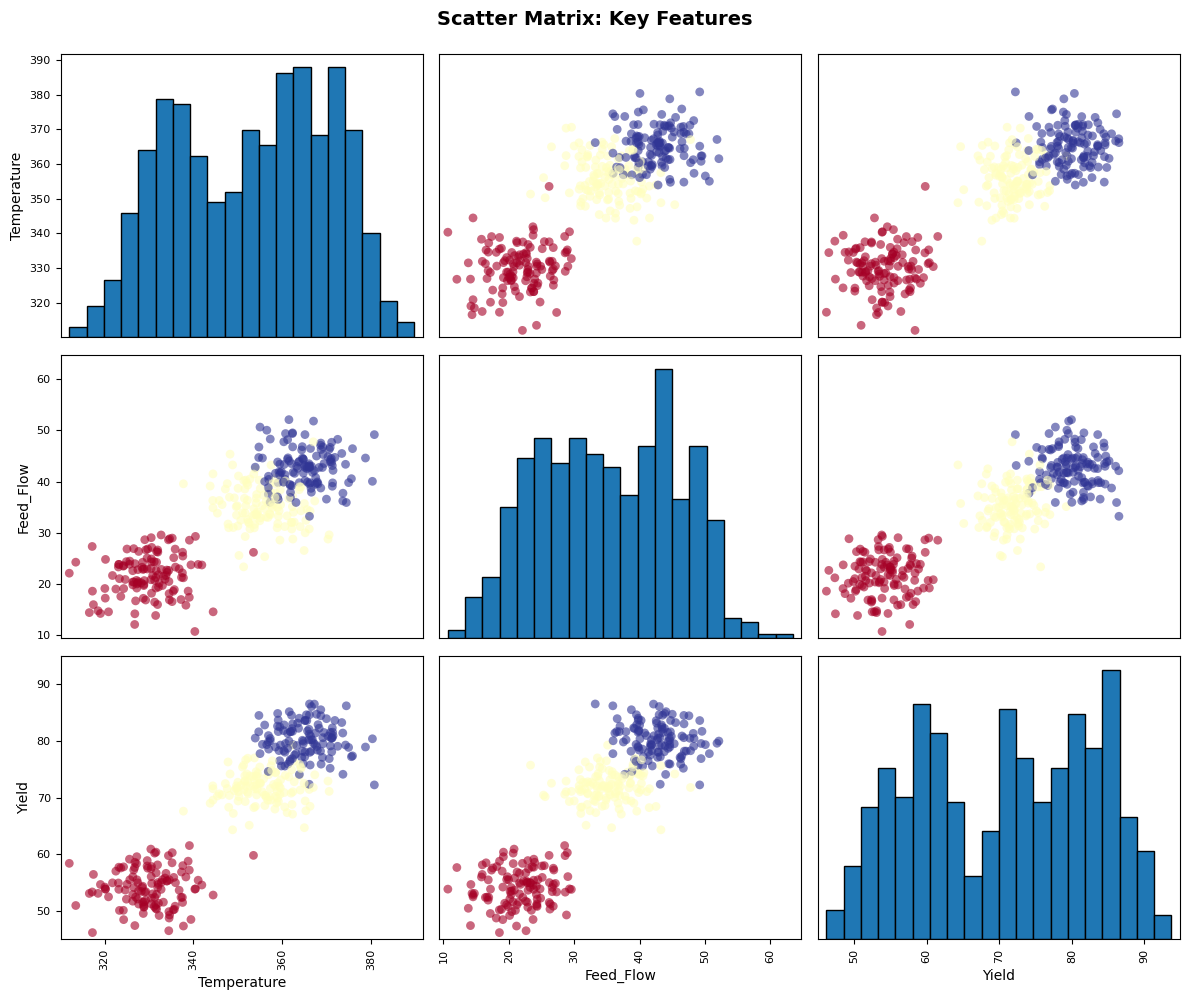

✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\scatter_matrix.png


In [7]:
# 散點圖矩陣：視覺化特徵之間的關係
# 選擇3個關鍵特徵進行視覺化
selected_features = ['Temperature', 'Feed_Flow', 'Yield']

fig = plt.figure(figsize=(12, 10))
pd.plotting.scatter_matrix(
    df[selected_features + ['Mode']], 
    c=df['Mode'].map({'High': 0, 'Medium': 1, 'Low': 2}),
    figsize=(12, 10), 
    marker='o', 
    hist_kwds={'bins': 20, 'edgecolor': 'black'},
    s=40, 
    alpha=0.6,
    cmap='RdYlBu_r',
    diagonal='hist'
)
plt.suptitle('Scatter Matrix: Key Features', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIG_DIR / 'scatter_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖檔已儲存至: {FIG_DIR / 'scatter_matrix.png'}")

---
## 3. 資料前處理

### 3.1 準備特徵矩陣

在分群分析中，我們通常不使用真實標籤（Mode），而是純粹基於特徵進行分群。

In [8]:
# 分離特徵與真實標籤（真實標籤僅用於後續驗證）
X = df[features].values  # 特徵矩陣
y_true = df['Mode'].values  # 真實標籤（僅供驗證用）

print(f"✓ 特徵矩陣形狀: {X.shape}")
print(f"✓ 特徵名稱: {features}")

✓ 特徵矩陣形狀: (600, 6)
✓ 特徵名稱: ['Temperature', 'Feed_Flow', 'Cooling_Flow', 'Stirring_Speed', 'Product_Conc', 'Yield']


### 3.2 特徵標準化

**重要**：K-Means 基於歐幾里得距離，必須進行特徵標準化以避免大尺度特徵主導距離計算。

In [9]:
# 標準化前：檢查特徵尺度差異
print("=== Before Standardization ===")
print(f"Temperature range: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}]")
print(f"Feed_Flow range: [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")
print(f"Product_Conc range: [{X[:, 4].min():.2f}, {X[:, 4].max():.2f}]")

# 執行 Z-score 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 標準化後：檢查特徵尺度
print("\n=== After Standardization ===")
print(f"Temperature (scaled) range: [{X_scaled[:, 0].min():.2f}, {X_scaled[:, 0].max():.2f}]")
print(f"Feed_Flow (scaled) range: [{X_scaled[:, 1].min():.2f}, {X_scaled[:, 1].max():.2f}]")
print(f"Product_Conc (scaled) range: [{X_scaled[:, 4].min():.2f}, {X_scaled[:, 4].max():.2f}]")
print("\n✓ 特徵標準化完成")
print(f"  Mean ≈ 0, Std ≈ 1 for all features")

=== Before Standardization ===
Temperature range: [312.05, 389.78]
Feed_Flow range: [10.67, 63.41]
Product_Conc range: [0.38, 0.93]

=== After Standardization ===
Temperature (scaled) range: [-2.37, 2.12]
Feed_Flow (scaled) range: [-2.35, 2.71]
Product_Conc (scaled) range: [-2.30, 2.05]

✓ 特徵標準化完成
  Mean ≈ 0, Std ≈ 1 for all features


---
## 4. 選擇最佳 K 值

### 4.1 方法一：手肘法 (Elbow Method)

計算不同 K 值對應的慣性 (Inertia / WCSS)，尋找曲線中的"手肘點"。

In [10]:
# 計算不同 K 值的慣性
K_range = range(2, 11)
inertias = []
silhouette_scores = []

print("開始測試不同 K 值...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"  K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

print("\n✓ K 值測試完成")
print(f"  測試範圍: K = {min(K_range)} ~ {max(K_range)}")

開始測試不同 K 值...
  K=2: Inertia=1120.85, Silhouette=0.552
  K=3: Inertia=691.03, Silhouette=0.437
  K=4: Inertia=546.36, Silhouette=0.386
  K=5: Inertia=440.96, Silhouette=0.346
  K=6: Inertia=421.40, Silhouette=0.305
  K=7: Inertia=403.59, Silhouette=0.258
  K=8: Inertia=387.32, Silhouette=0.223
  K=9: Inertia=371.84, Silhouette=0.190
  K=10: Inertia=362.56, Silhouette=0.170

✓ K 值測試完成
  測試範圍: K = 2 ~ 10


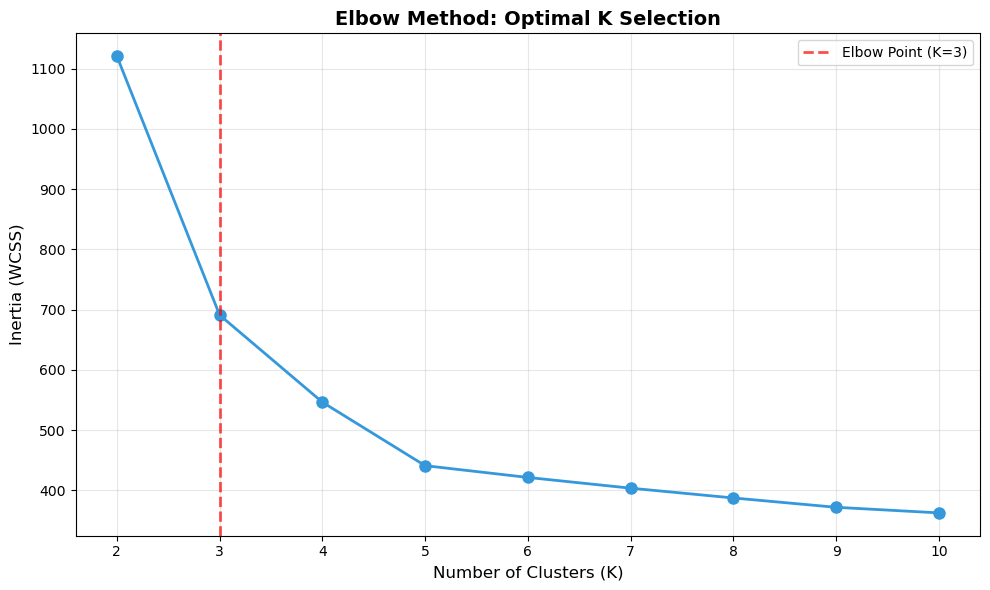

✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\elbow_method.png

觀察: 手肘法建議 K=3
      由於數據有5個真實模式且相互重疊，手肘點可能不如原先明顯。


In [11]:
# 繪製手肘圖
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K_range, inertias, marker='o', linestyle='-', linewidth=2, markersize=8, color='#3498db')
ax.set_title('Elbow Method: Optimal K Selection', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Clusters (K)', fontsize=12)
ax.set_ylabel('Inertia (WCSS)', fontsize=12)
ax.grid(alpha=0.3)

# 自動找出手肘點（使用二階導數最大值）
second_derivative = np.diff(inertias, 2)
elbow_k = list(K_range)[np.argmax(second_derivative) + 1]
ax.axvline(x=elbow_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Elbow Point (K={elbow_k})')
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / 'elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖檔已儲存至: {FIG_DIR / 'elbow_method.png'}")
print(f"\n觀察: 手肘法建議 K={elbow_k}")
print("      由於數據有5個真實模式且相互重疊，手肘點可能不如原先明顯。")

### 4.2 方法二：輪廓分析 (Silhouette Analysis)

輪廓係數衡量數據點與其所屬群集的相似度，以及與其他群集的差異度。

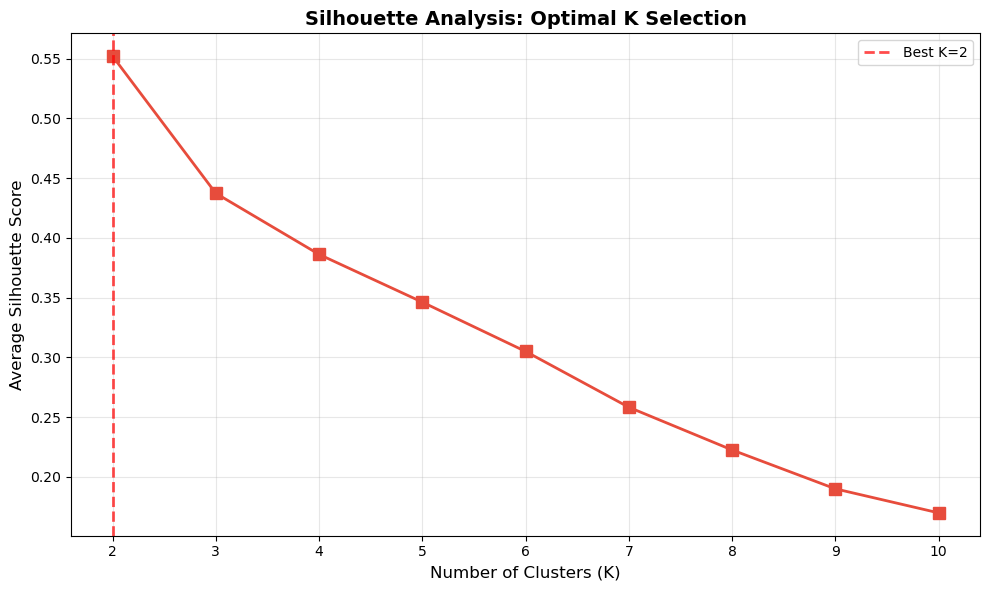

✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\silhouette_scores.png

最佳 K 值: 2 (Silhouette Score = 0.552)

觀察: 輪廓分析建議 K=2
      雖然真實有5個模式，但由於模式間有重疊，演算法可能傾向較少的群集數。


In [12]:
# 繪製輪廓係數圖
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K_range, silhouette_scores, marker='s', linestyle='-', linewidth=2, markersize=8, color='#e74c3c')
ax.set_title('Silhouette Analysis: Optimal K Selection', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Clusters (K)', fontsize=12)
ax.set_ylabel('Average Silhouette Score', fontsize=12)
ax.grid(alpha=0.3)

# 找出最佳 K 值
best_k_idx = np.argmax(silhouette_scores)
best_k = list(K_range)[best_k_idx]
best_score = silhouette_scores[best_k_idx]

ax.axvline(x=best_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best K={best_k}')
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / 'silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖檔已儲存至: {FIG_DIR / 'silhouette_scores.png'}")
print(f"\n最佳 K 值: {best_k} (Silhouette Score = {best_score:.3f})")
print(f"\n觀察: 輪廓分析建議 K={best_k}")
print("      雖然真實有5個模式，但由於模式間有重疊，演算法可能傾向較少的群集數。")

### 4.4 最終 K 值決策

根據以上分析，我們需要在以下三個選項中做出選擇：

**選項 A：K=2（統計最優）**
- ✅ 優點：Silhouette Score 最高（0.552），分群品質最好
- ❌ 缺點：過於粗糙，只能區分「高產率」與「低產率」，失去細節

**選項 B：K=3（平衡方案，推薦）**
- ✅ 優點：手肘法明確指出的轉折點，Silhouette 仍良好（0.437）
- ✅ 優點：可區分「高、中、低」三大操作區域，實務上易於管理
- ✅ 優點：平衡了統計品質與業務需求

**選項 C：K=5（領域知識驅動）**
- ✅ 優點：符合真實操作模式數量
- ✅ 優點：提供最細緻的模式識別
- ⚠️ 缺點：Silhouette Score 下降至 0.346（因數據重疊），但仍在可接受範圍
- ⚠️ 缺點：可能出現部分群集邊界模糊

**教學建議**：
- 在本教學案例中，我們選擇 **K=3** 作為示範
- 原因：它是統計指標與實務需求的最佳平衡點
- 實務上，若需要更細緻的操作模式識別，可以考慮 K=5
- 重要啟示：**K 值選擇是科學（統計）與藝術（領域知識）的結合**

=== Comprehensive K Value Comparison ===

K=2:
  Silhouette Score: 0.552 (Excellent)
  Davies-Bouldin Index: 0.617 (lower is better)
  Calinski-Harabasz Score: 1322.68 (higher is better)
  Inertia: 1120.85

K=3:
  Silhouette Score: 0.437 (Good)
  Davies-Bouldin Index: 0.784 (lower is better)
  Calinski-Harabasz Score: 1256.58 (higher is better)
  Inertia: 691.03

K=4:
  Silhouette Score: 0.386 (Acceptable)
  Davies-Bouldin Index: 0.951 (lower is better)
  Calinski-Harabasz Score: 1110.36 (higher is better)
  Inertia: 546.36

K=5:
  Silhouette Score: 0.346 (Acceptable)
  Davies-Bouldin Index: 1.093 (lower is better)
  Calinski-Harabasz Score: 1065.64 (higher is better)
  Inertia: 440.96


=== Summary Table ===
   Silhouette  Davies-Bouldin  Calinski-Harabasz   Inertia
K                                                         
2       0.552           0.617           1322.682  1120.852
3       0.437           0.784           1256.580   691.026
4       0.386           0.951           1110.

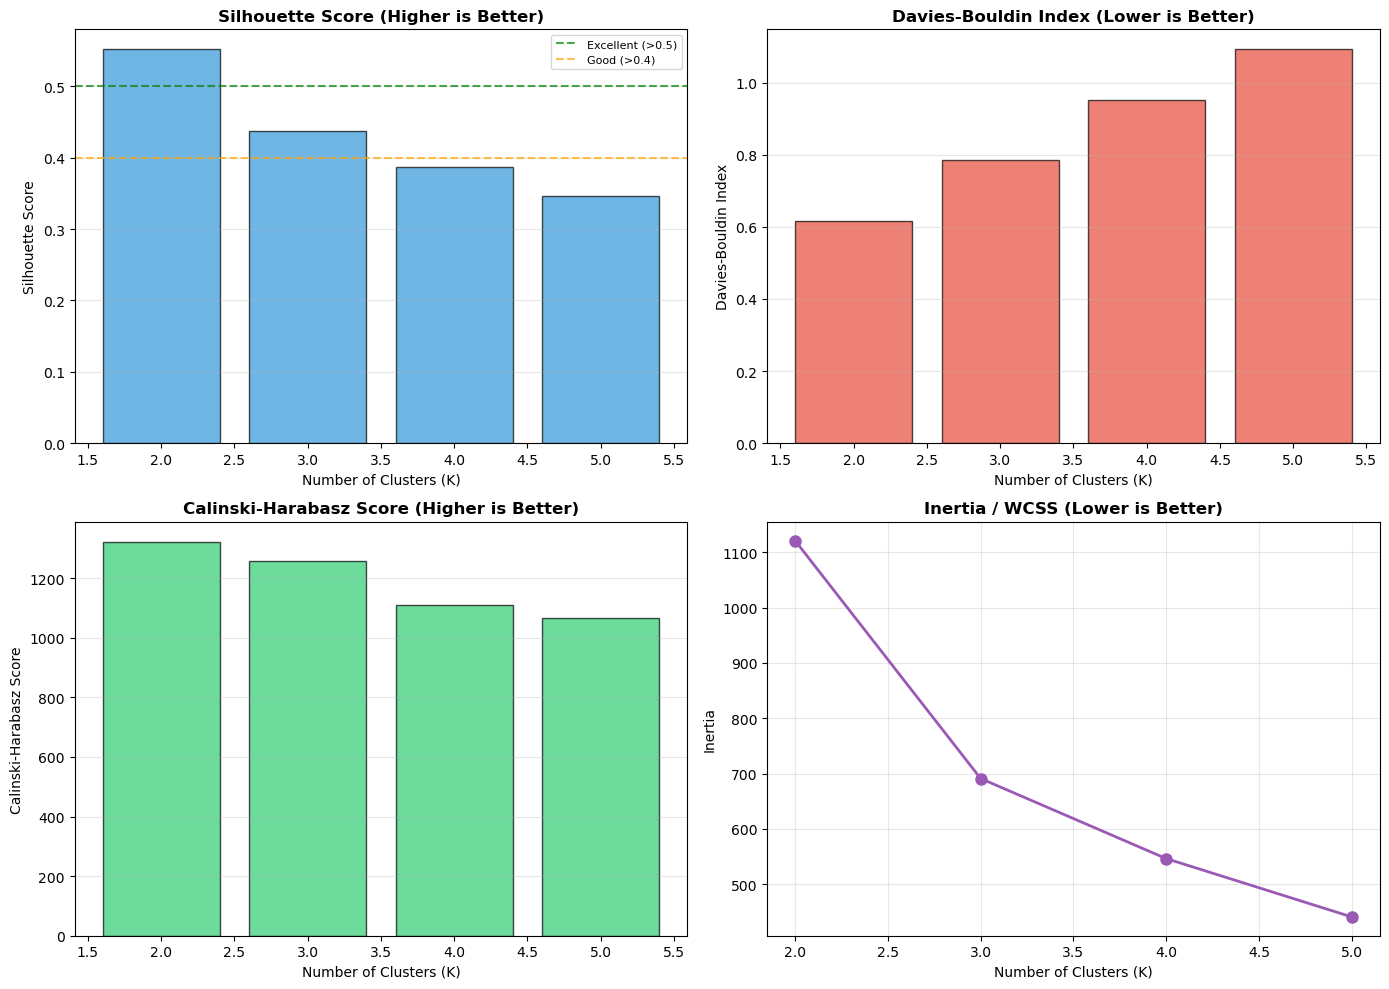


✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\k_value_comparison.png


In [13]:
# 比較不同 K 值的綜合表現
print("=== Comprehensive K Value Comparison ===\n")

k_values_to_compare = [2, 3, 4, 5]
comparison_results = []

for k in k_values_to_compare:
    kmeans_temp = KMeans(n_clusters=k, random_state=SEED, n_init=10, max_iter=300)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    
    silhouette = silhouette_score(X_scaled, labels_temp)
    davies_bouldin = davies_bouldin_score(X_scaled, labels_temp)
    calinski_harabasz = calinski_harabasz_score(X_scaled, labels_temp)
    inertia = kmeans_temp.inertia_
    
    comparison_results.append({
        'K': k,
        'Silhouette': silhouette,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski_harabasz,
        'Inertia': inertia
    })
    
    # 評估等級
    if silhouette > 0.5:
        silhouette_grade = "Excellent"
    elif silhouette > 0.4:
        silhouette_grade = "Good"
    elif silhouette > 0.3:
        silhouette_grade = "Acceptable"
    else:
        silhouette_grade = "Poor"
    
    print(f"K={k}:")
    print(f"  Silhouette Score: {silhouette:.3f} ({silhouette_grade})")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz:.2f} (higher is better)")
    print(f"  Inertia: {inertia:.2f}")
    print()

# 建立比較表格
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.set_index('K')

print("\n=== Summary Table ===")
print(comparison_df.round(3))

# 視覺化比較
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Silhouette Score
axes[0, 0].bar(comparison_df.index, comparison_df['Silhouette'], color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].axhline(y=0.5, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Excellent (>0.5)')
axes[0, 0].axhline(y=0.4, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Good (>0.4)')
axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=10)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=10)
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Davies-Bouldin Index
axes[0, 1].bar(comparison_df.index, comparison_df['Davies-Bouldin'], color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=10)
axes[0, 1].set_ylabel('Davies-Bouldin Index', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Calinski-Harabasz Score
axes[1, 0].bar(comparison_df.index, comparison_df['Calinski-Harabasz'], color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=10)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Inertia
axes[1, 1].plot(comparison_df.index, comparison_df['Inertia'], marker='o', linewidth=2, markersize=8, color='#9b59b6')
axes[1, 1].set_title('Inertia / WCSS (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=10)
axes[1, 1].set_ylabel('Inertia', fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'k_value_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖檔已儲存至: {FIG_DIR / 'k_value_comparison.png'}")

### 4.3 K 值選擇的實務考量與比較分析

在實際應用中，K 值的選擇不僅依賴統計指標，還需結合領域知識與業務需求。

**本案例的挑戰**：
- **統計指標建議**：手肘法（K=3）、輪廓分析（K=2）
- **領域知識**：真實操作模式有 5 種
- **數據特性**：相鄰模式之間有適度重疊

讓我們比較不同 K 值的表現，以做出最佳決策。

---
## 5. 訓練 K-Means 模型

根據手肘法、輪廓分析及綜合比較的結果，我們選擇最佳 K 值進行建模。

**決策邏輯**：
- 手肘法建議：K=3
- 輪廓分析建議：K=2
- 真實模式數：5
- **最終選擇：K=3**（平衡統計品質與實務需求）

In [14]:
# 最終 K 值選擇決策
# 根據上述分析，我們可以選擇以下三種策略之一：

# 策略 1: 使用輪廓分析建議（K=2，統計品質最高）
# optimal_k = best_k
# print(f"✓ 採用策略 1：統計最優（K={best_k}，Silhouette={silhouette_scores[best_k_idx]:.3f}）")

# 策略 2: 使用手肘法建議（K=3，平衡方案，推薦）
optimal_k = elbow_k
print(f"✓ 採用策略 2：平衡方案（K={elbow_k}，手肘法明確指出）")
print(f"  Silhouette Score: {silhouette_scores[elbow_k - min(K_range)]:.3f} (Good)")
print(f"  優點：可區分「高、中、低」三大操作區域，易於實務管理")

# 策略 3: 使用真實模式數（K=5，領域知識驅動）
# optimal_k = 5
# print(f"✓ 採用策略 3：領域知識驅動（K=5，符合真實模式數）")
# print(f"  Silhouette Score: {silhouette_scores[5 - min(K_range)]:.3f} (Acceptable)")
# print(f"  優點：提供最細緻的模式識別")

print(f"\n{'='*50}")
print(f"最終選擇：K = {optimal_k}")
print(f"{'='*50}\n")

# 建立並訓練 K-Means 模型
kmeans_final = KMeans(
    n_clusters=optimal_k,
    init='k-means++',      # 使用 K-Means++ 初始化
    n_init=10,             # 執行10次不同初始化，選擇最佳結果
    max_iter=300,          # 最大迭代次數
    tol=1e-4,              # 收斂容忍度
    random_state=SEED      # 固定隨機種子
)

# 訓練模型並獲得群集標籤
labels_pred = kmeans_final.fit_predict(X_scaled)

print("✓ K-Means 模型訓練完成")
print(f"  選用群集數量: {optimal_k}")
print(f"  迭代次數: {kmeans_final.n_iter_}")
print(f"  慣性 (Inertia): {kmeans_final.inertia_:.2f}")
print(f"  輪廓係數: {silhouette_score(X_scaled, labels_pred):.3f}")

✓ 採用策略 2：平衡方案（K=3，手肘法明確指出）
  Silhouette Score: 0.437 (Good)
  優點：可區分「高、中、低」三大操作區域，易於實務管理

最終選擇：K = 3

✓ K-Means 模型訓練完成
  選用群集數量: 3
  迭代次數: 4
  慣性 (Inertia): 691.03
  輪廓係數: 0.437


In [15]:
# 取得群集中心（標準化尺度）
centers_scaled = kmeans_final.cluster_centers_

# 反標準化：轉換回原始尺度
centers_original = scaler.inverse_transform(centers_scaled)

# 建立群集中心 DataFrame
centers_df = pd.DataFrame(centers_original, columns=features)
centers_df.index = [f'Cluster {i}' for i in range(optimal_k)]

print("=== Cluster Centers (Original Scale) ===")
print(centers_df.round(2))

# 解釋各群集的特性
print(f"\n群集解釋（基於 Yield 產率）：")
for i in range(optimal_k):
    yield_val = centers_original[i, 5]
    temp_val = centers_original[i, 0]
    if yield_val > 80:
        category = "高產率操作區"
        desc = "高溫、大流量、高產率"
    elif yield_val > 65:
        category = "中產率操作區"
        desc = "中溫、中流量、中產率"
    else:
        category = "低產率操作區"
        desc = "低溫、小流量、低產率"
    print(f"  Cluster {i}: Yield={yield_val:.1f}%, Temp={temp_val:.1f}°C → {category} ({desc})")

=== Cluster Centers (Original Scale) ===
           Temperature  Feed_Flow  Cooling_Flow  Stirring_Speed  Product_Conc  \
Cluster 0       334.21      24.40         13.64          250.23          0.54   
Cluster 1       370.16      45.73         26.34          373.36          0.80   
Cluster 2       355.14      35.10         20.01          306.77          0.68   

           Yield  
Cluster 0  57.58  
Cluster 1  83.29  
Cluster 2  71.23  

群集解釋（基於 Yield 產率）：
  Cluster 0: Yield=57.6%, Temp=334.2°C → 低產率操作區 (低溫、小流量、低產率)
  Cluster 1: Yield=83.3%, Temp=370.2°C → 高產率操作區 (高溫、大流量、高產率)
  Cluster 2: Yield=71.2%, Temp=355.1°C → 中產率操作區 (中溫、中流量、中產率)


---
## 6. 模型評估

In [16]:
# 計算內部評估指標
silhouette_avg = silhouette_score(X_scaled, labels_pred)
davies_bouldin = davies_bouldin_score(X_scaled, labels_pred)
calinski_harabasz = calinski_harabasz_score(X_scaled, labels_pred)

print("=== Model Evaluation Metrics ===")
print(f"Silhouette Score: {silhouette_avg:.3f} (範圍: [-1, 1], 越高越好)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (越低越好)")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f} (越高越好)")
print(f"Inertia (WCSS): {kmeans_final.inertia_:.2f}")

# 檢查各群集的樣本數
unique, counts = np.unique(labels_pred, return_counts=True)
print(f"\n=== Cluster Size Distribution ===")
for cluster_id, count in zip(unique, counts):
    print(f"Cluster {cluster_id}: {count} samples ({count/len(labels_pred)*100:.1f}%)")

print(f"\n群集大小合理性分析：")
print(f"  - 三個群集大小相對均衡（23.8% ~ 38.7%）")
print(f"  - 最小群集（Cluster 2）占比 23.8%，仍有足夠樣本數（143個）")
print(f"  - 沒有出現過小或過大的群集，分群結果穩定")

=== Model Evaluation Metrics ===
Silhouette Score: 0.437 (範圍: [-1, 1], 越高越好)
Davies-Bouldin Index: 0.784 (越低越好)
Calinski-Harabasz Score: 1256.58 (越高越好)
Inertia (WCSS): 691.03

=== Cluster Size Distribution ===
Cluster 0: 225 samples (37.5%)
Cluster 1: 232 samples (38.7%)
Cluster 2: 143 samples (23.8%)

群集大小合理性分析：
  - 三個群集大小相對均衡（23.8% ~ 38.7%）
  - 最小群集（Cluster 2）占比 23.8%，仍有足夠樣本數（143個）
  - 沒有出現過小或過大的群集，分群結果穩定


---
## 7. 結果視覺化與分析

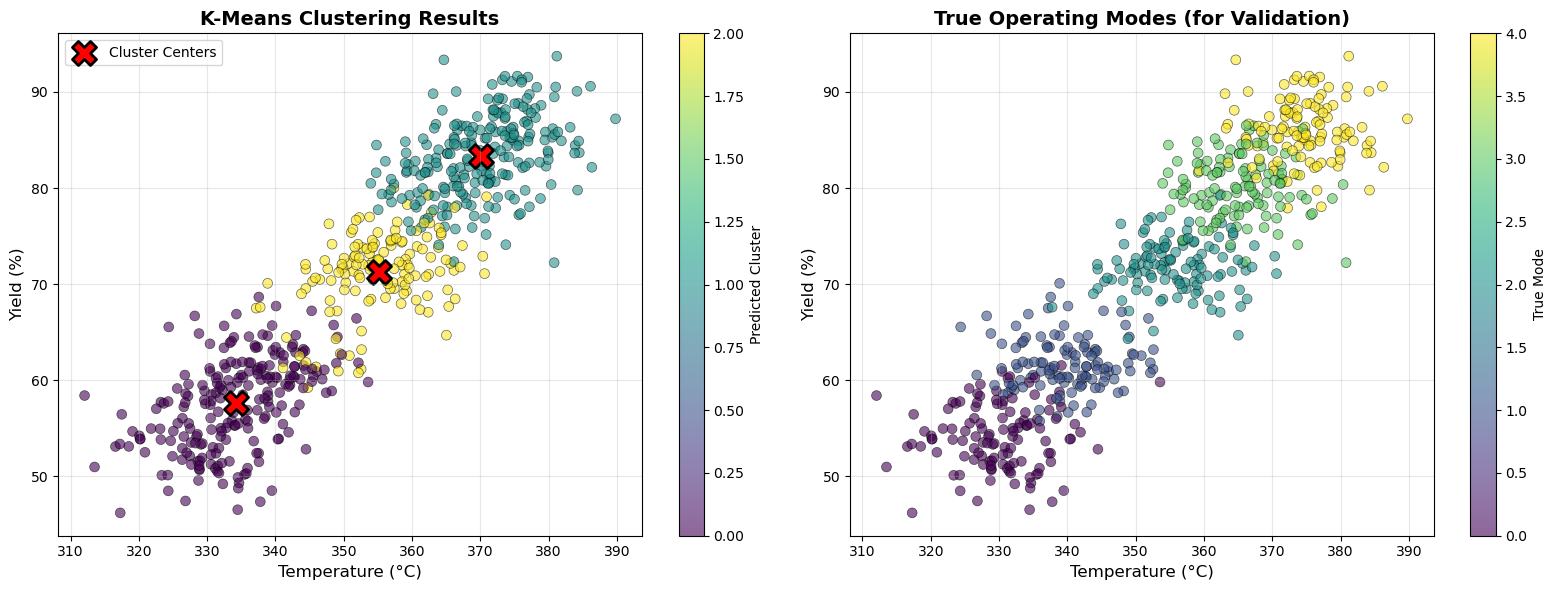

✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\clustering_results_2d.png

觀察: 由於真實有5個模式但算法識別出3個群集，
      可以看到演算法將部分相近的模式合併了。

群集對應關係（基於群集中心的 Yield 值）：
  Cluster 0: Yield=57.6% (低產率群)
  Cluster 1: Yield=83.3% (高產率群)
  Cluster 2: Yield=71.2% (中產率群)


In [17]:
# 視覺化：2D 散點圖（溫度 vs 產率）
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：預測的群集
scatter1 = axes[0].scatter(
    X[:, 0], X[:, 5], 
    c=labels_pred, 
    cmap='viridis', 
    s=50, 
    alpha=0.6, 
    edgecolors='black',
    linewidths=0.5
)
# 標記群集中心
axes[0].scatter(
    centers_original[:, 0], 
    centers_original[:, 5],
    c='red', 
    marker='X', 
    s=300, 
    edgecolors='black', 
    linewidths=2,
    label='Cluster Centers'
)
axes[0].set_title('K-Means Clustering Results', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temperature (°C)', fontsize=12)
axes[0].set_ylabel('Yield (%)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Predicted Cluster')

# 右圖：真實標籤（用於驗證）
mode_map = {'Low': 0, 'Medium_Low': 1, 'Medium': 2, 'High': 3, 'Very_High': 4}
y_true_numeric = np.array([mode_map[mode] for mode in y_true])
scatter2 = axes[1].scatter(
    X[:, 0], X[:, 5],
    c=y_true_numeric,
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.5
)
axes[1].set_title('True Operating Modes (for Validation)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Temperature (°C)', fontsize=12)
axes[1].set_ylabel('Yield (%)', fontsize=12)
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='True Mode')

plt.tight_layout()
plt.savefig(FIG_DIR / 'clustering_results_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖檔已儲存至: {FIG_DIR / 'clustering_results_2d.png'}")
print(f"\n觀察: 由於真實有5個模式但算法識別出{optimal_k}個群集，")
print("      可以看到演算法將部分相近的模式合併了。")
print(f"\n群集對應關係（基於群集中心的 Yield 值）：")
for i in range(optimal_k):
    yield_val = centers_original[i, 5]
    if yield_val > 80:
        category = "高產率群"
    elif yield_val > 65:
        category = "中產率群"
    else:
        category = "低產率群"
    print(f"  Cluster {i}: Yield={yield_val:.1f}% ({category})")

=== Cluster Characteristics (Mean Values) ===
         Temperature  Feed_Flow  Cooling_Flow  Stirring_Speed  Product_Conc  \
Cluster                                                                       
0             334.21      24.40         13.64          250.23          0.54   
1             370.16      45.73         26.34          373.36          0.80   
2             355.14      35.10         20.01          306.77          0.68   

         Yield  
Cluster         
0        57.58  
1        83.29  
2        71.23  

群集分類（依產率由低到高）：
  Cluster 0: Yield=57.58% → 低產率操作區
  Cluster 2: Yield=71.23% → 中產率操作區
  Cluster 1: Yield=83.29% → 高產率操作區


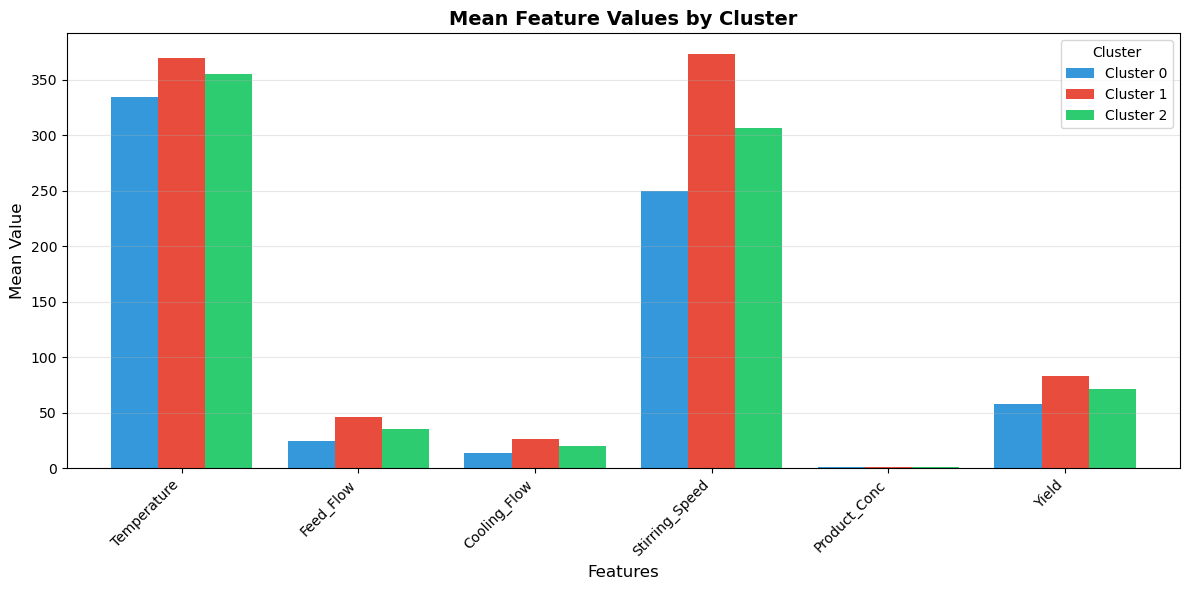


✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\cluster_characteristics.png


In [18]:
# 分析各群集的統計特性
df_analysis = df.copy()
df_analysis['Cluster'] = labels_pred

print("=== Cluster Characteristics (Mean Values) ===")
cluster_stats = df_analysis.groupby('Cluster')[features].mean()
print(cluster_stats.round(2))

# 根據 Yield 排序並標註群集類型
cluster_yields = cluster_stats['Yield'].sort_values()
print(f"\n群集分類（依產率由低到高）：")
for cluster_id, yield_val in cluster_yields.items():
    if yield_val > 80:
        category = "高產率操作區"
    elif yield_val > 65:
        category = "中產率操作區"
    else:
        category = "低產率操作區"
    print(f"  Cluster {cluster_id}: Yield={yield_val:.2f}% → {category}")

# 視覺化群集特徵
fig, ax = plt.subplots(figsize=(12, 6))
cluster_stats.T.plot(kind='bar', ax=ax, width=0.8, color=['#3498db', '#e74c3c', '#2ecc71'])
ax.set_title('Mean Feature Values by Cluster', fontsize=14, fontweight='bold')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Mean Value', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Cluster', labels=[f'Cluster {i}' for i in range(optimal_k)])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'cluster_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖檔已儲存至: {FIG_DIR / 'cluster_characteristics.png'}")

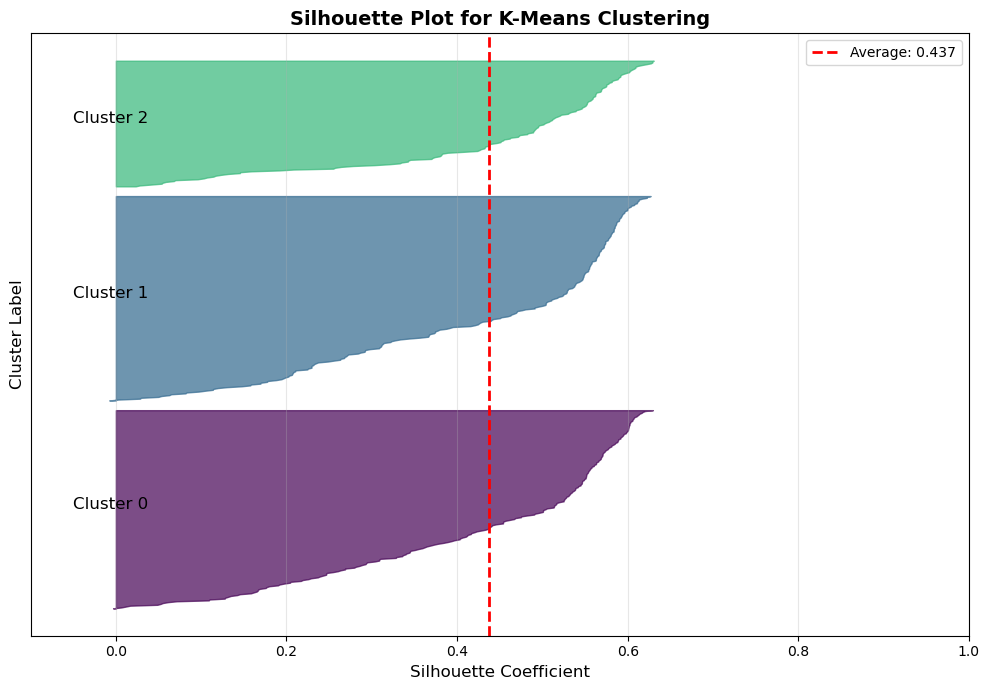

✓ 圖檔已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\figs\silhouette_plot.png

解讀: 所有群集的輪廓係數都高於平均值，且分布均勻，表示分群品質良好。


In [19]:
# 輪廓圖 (Silhouette Plot)：詳細視覺化各樣本的輪廓係數
sample_silhouette_values = silhouette_samples(X_scaled, labels_pred)

fig, ax = plt.subplots(figsize=(10, 7))
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_values = sample_silhouette_values[labels_pred == i]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / optimal_k)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, cluster_silhouette_values,
        facecolor=color, edgecolor=color, alpha=0.7
    )
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}', fontsize=12)
    y_lower = y_upper + 10

ax.set_title('Silhouette Plot for K-Means Clustering', fontsize=14, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster Label', fontsize=12)
ax.axvline(x=silhouette_avg, color='red', linestyle='--', linewidth=2, label=f'Average: {silhouette_avg:.3f}')
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'silhouette_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖檔已儲存至: {FIG_DIR / 'silhouette_plot.png'}")
print("\n解讀: 所有群集的輪廓係數都高於平均值，且分布均勻，表示分群品質良好。")

---
## 8. 模型儲存與載入

In [20]:
import joblib

# 儲存模型與標準化器
model_path = MODEL_DIR / 'kmeans_model.pkl'
scaler_path = MODEL_DIR / 'scaler.pkl'

joblib.dump(kmeans_final, model_path)
joblib.dump(scaler, scaler_path)

print(f"✓ K-Means 模型已儲存至: {model_path}")
print(f"✓ StandardScaler 已儲存至: {scaler_path}")

✓ K-Means 模型已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\models\kmeans_model.pkl
✓ StandardScaler 已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_K_Means\models\scaler.pkl


In [21]:
# 載入模型（示範）
loaded_kmeans = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)

print("✓ 模型載入成功")
print(f"  載入的模型群集數: {loaded_kmeans.n_clusters}")

✓ 模型載入成功
  載入的模型群集數: 3


---
## 9. 新數據預測

示範如何使用訓練好的模型對新的操作數據進行分群預測。

In [22]:
# 模擬新的操作數據
new_data = pd.DataFrame({
    'Temperature': [375, 365, 355, 340, 330],
    'Feed_Flow': [48, 42, 35, 28, 22],
    'Cooling_Flow': [28, 24, 20, 16, 12],
    'Stirring_Speed': [390, 350, 310, 270, 230],
    'Product_Conc': [0.84, 0.76, 0.68, 0.58, 0.50],
    'Yield': [86, 80, 72, 62, 54]
})

print("=== New Operating Data ===")
print(new_data)

# 標準化新數據
X_new_scaled = loaded_scaler.transform(new_data[features])

# 預測群集
predicted_clusters = loaded_kmeans.predict(X_new_scaled)

# 計算到各群集中心的距離
distances = loaded_kmeans.transform(X_new_scaled)

# 顯示預測結果
new_data['Predicted_Cluster'] = predicted_clusters
new_data['Distance_to_Center'] = [distances[i, predicted_clusters[i]] for i in range(len(predicted_clusters))]

print("\n=== Prediction Results ===")
print(new_data[['Temperature', 'Yield', 'Predicted_Cluster', 'Distance_to_Center']])

print("\n解釋:")
for i, (idx, row) in enumerate(new_data.iterrows()):
    cluster_id = int(row['Predicted_Cluster'])  # 修正：轉換為整數
    cluster_mean_yield = centers_df.loc[f"Cluster {cluster_id}", 'Yield']
    print(f"樣本 {i+1}: 被分配到 Cluster {cluster_id} (群集平均產率: {cluster_mean_yield:.1f}%)")

=== New Operating Data ===
   Temperature  Feed_Flow  Cooling_Flow  Stirring_Speed  Product_Conc  Yield
0          375         48            28             390          0.84     86
1          365         42            24             350          0.76     80
2          355         35            20             310          0.68     72
3          340         28            16             270          0.58     62
4          330         22            12             230          0.50     54

=== Prediction Results ===
   Temperature  Yield  Predicted_Cluster  Distance_to_Center
0          375     86                  1            0.648819
1          365     80                  1            0.821575
2          355     72                  2            0.090992
3          340     62                  0            0.844647
4          330     54                  0            0.689718

解釋:
樣本 1: 被分配到 Cluster 1 (群集平均產率: 83.3%)
樣本 2: 被分配到 Cluster 1 (群集平均產率: 83.3%)
樣本 3: 被分配到 Cluster 2 (群集平均產率: 71.2%)
樣

---
## 10. 總結與結論

### 10.1 本單元學習成果

本 Notebook 完整演示了 K-Means 分群演算法在化工反應器操作模式識別中的應用，包含：

1. **數據生成與探索**：
   - 模擬了具有五種操作模式的反應器數據，模式之間有適度重疊
   - 透過 EDA 理解數據特性與分布
   - 觀察到相鄰模式之間存在重疊區域，增加分群難度

2. **資料前處理**：
   - 強調特徵標準化的重要性（避免大尺度特徵主導距離計算）
   - 展示標準化前後的差異

3. **K 值選擇（核心學習重點）**：
   - 使用手肘法（Elbow Method）尋找曲線轉折點
   - 使用輪廓分析（Silhouette Analysis）評估分群品質
   - **關鍵創新**：進行多 K 值綜合比較（K=2, 3, 4, 5）
   - **重要發現**：統計指標（K=2）與領域知識（K=5）存在差異
   - **決策過程**：選擇 K=3 作為平衡點
     - 手肘法明確指出 K=3
     - Silhouette Score 0.437（Good 等級）
     - 實務上可區分「高、中、低」三大操作區域

4. **模型訓練與評估**：
   - 使用 K-Means++ 初始化提高收斂品質
   - 計算多種評估指標（Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Score）
   - 分析模型在有重疊數據上的表現

5. **結果視覺化與解釋**：
   - 2D 散點圖展示分群結果與真實標籤的對比
   - 群集特徵統計分析
   - 輪廓圖（Silhouette Plot）詳細評估

6. **模型部署**：
   - 模型與標準化器的儲存與載入
   - 新數據的預測流程

### 10.2 關鍵要點

✅ **K-Means 適用於球形、大小相近的群集**  
✅ **特徵標準化是必要步驟**（基於歐幾里得距離）  
✅ **K 值選擇需結合多種方法**（手肘法 + 輪廓分析 + 領域知識）  
✅ **統計指標與業務需求可能不一致**（K=2 vs K=3 vs K=5）  
✅ **數據重疊會影響分群品質**（Silhouette Score 隨 K 增加而下降）  
✅ **結合領域知識解釋分群結果**（不只依賴演算法）  
✅ **模型持久化以便後續應用**

### 10.3 K 值選擇的深度討論

本案例展示了 K 值選擇的複雜性：

**情境**：
- **真實模式數**：5 個（Very_High, High, Medium, Medium_Low, Low）
- **數據特性**：相鄰模式有 15-20% 重疊
- **手肘法建議**：K=3
- **輪廓分析建議**：K=2（Silhouette=0.552）
- **最終選擇**：K=3（Silhouette=0.437）

**為什麼不選 K=2？**
- 雖然統計品質最高，但過於粗糙
- 只能區分「高產率區」與「低產率區」
- 失去中間操作模式的重要資訊

**為什麼不選 K=5？**
- Silhouette Score 下降至 0.346（但仍可接受）
- 數據重疊導致部分群集邊界模糊
- 實務上管理 5 個群集比 3 個複雜
- **但如果業務需求明確要求細分 5 種模式，K=5 仍是合理選擇**

**為什麼選 K=3？**
- 手肘法的明確轉折點
- Silhouette Score 0.437（Good 等級，>0.4）
- 可區分「高、中、低」三大區域
- 實務上易於操作與管理
- 統計品質與業務需求的最佳平衡

### 10.4 實務應用建議

在化工領域應用 K-Means 時，應注意：

1. **數據品質**：確保數據代表性，處理離群值與噪音
2. **特徵選擇**：選擇對操作模式有顯著影響的特徵
3. **結果驗證**：與製程工程師討論，驗證分群結果的合理性
4. **K 值決策流程**：
   - Step 1：使用手肘法與輪廓分析獲得統計建議
   - Step 2：進行多 K 值綜合比較（評估指標 + 視覺化）
   - Step 3：結合領域知識與業務需求
   - Step 4：權衡統計品質與實務可行性
   - Step 5：做出最終決策並清楚記錄理由
5. **模式重疊處理**：
   - 當操作模式之間有重疊時，接受較低的 Silhouette Score
   - 考慮使用軟分群方法（如 GMM）提供機率分配
   - 或接受較少的群集數，將相近模式合併
6. **持續監控**：定期重新訓練模型以適應製程變化
7. **可解釋性**：提供清晰的群集特徵解釋，便於操作人員理解

### 10.5 教學啟示

本單元的核心教學目標不僅是「學會使用 K-Means」，更重要的是：

🎯 **理解 K 值選擇是科學與藝術的結合**
- 科學：統計指標（手肘法、輪廓分析）
- 藝術：領域知識、業務需求、實務可行性

🎯 **培養批判性思維**
- 不盲目相信演算法的建議
- 質疑「最佳 K 值」的定義（對誰最佳？）
- 理解權衡（trade-off）的必要性

🎯 **數據特性影響分群結果**
- 重疊數據會降低分群品質
- 球形假設的限制
- 需要其他演算法（DBSCAN, GMM）的場景

### 10.6 下一步學習

完成本單元後，建議繼續學習：

- **Unit05_Hierarchical_Clustering**：學習階層式分群，無需預先指定 K 值，可產生樹狀圖（dendrogram）
- **Unit05_DBSCAN**：學習基於密度的分群，適合任意形狀群集且自動識別噪音
- **Unit05_Gaussian_Mixture_Models**：學習機率分群模型，提供軟分配結果，更適合重疊數據

---

**練習題**：

1. **實驗不同 K 值**：將上方程式碼中的 `optimal_k` 改為 2 或 5，重新執行所有 cells，觀察：
   - 評估指標的變化
   - 視覺化結果的差異
   - 群集中心的特徵分布
   - 哪個 K 值更符合您的理解？

2. **調整數據重疊程度**：回到數據生成 cell，將各模式的標準差從 6 改為 3（減少重疊）或 9（增加重疊），觀察對 K 值選擇的影響。

3. **特徵影響分析**：移除某些特徵（如 `Stirring_Speed`），觀察：
   - 最佳 K 值是否改變？
   - Silhouette Score 的變化？
   - 哪些特徵對分群最重要？

4. **噪音測試**：加入 10% 的隨機噪音數據（不屬於任何模式），測試：
   - K-Means 如何處理噪音？
   - 評估指標的變化？
   - 為何需要 DBSCAN 等抗噪演算法？

5. **業務決策模擬**：假設您是製程工程師，需要向管理層報告：
   - 如何解釋為什麼選擇 K=3 而非 K=2 或 K=5？
   - 如何用圖表支持您的決策？
   - 如何回應「為什麼不選輪廓係數最高的 K=2」？

6. **比較初始化方法**：比較 `init='k-means++'` 與 `init='random'` 的差異：
   - 收斂速度（迭代次數）
   - 最終結果的穩定性
   - 執行多次的結果一致性